# Multi-center Tonal Diffusion Model evaluation attempt (unfinished and unclean)

## 1. Library import

In [ ]:
import os

# data analysis
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# initialisation and oprimisation of models
import torch
from torch.distributions.poisson import Poisson
from torch.distributions.binomial import Binomial
from torch.distributions.gamma import Gamma
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from torch.optim import Adam
from tqdm import tqdm

# the generalised tdm
from generalised_tdm import TonalDiffusionModel

# statistical test
from scipy.stats import mannwhitneyu

## 2. Functions

### 2.1 Auxiliary functions for debugging step by step (they were extracted from the TDM implementation)

In [ ]:
_eps = 1e-50

# used in the imp
def binom_logprob_manual_kNk(k, N, p):
    p_clamped = torch.clamp(p, _eps, 1.0 - _eps)
    log_choose = torch.lgamma(N + 1.0) - torch.lgamma(k + 1.0) - torch.lgamma(N - k + 1.0)
    return log_choose + k * torch.log(p_clamped) + (N - k) * torch.log(1.0 - p_clamped)


## 3. Data import

In [ ]:
faure = pd.read_csv(r"C:\Users\sacha\OneDrive\Documents\testPython\myvenv\tdm\CorpusFaureREAL.csv")

def do_count(dataset):
    # reducing the dataset to TPCs (tonal pitch classes), assigning weights to pieces, gathering their titles
    weights = np.ones(len(dataset))
    titles = dataset.title.values
    counts = dataset.iloc[:, :-10].values
    data = counts / counts.sum(axis = 1, keepdims = True)
    return data, weights, titles
data_faure, weights_faure, titles_faure = do_count(faure)
data_second, weights_second, titles_second = do_count(faure[faure["periode"] == 2].reset_index(drop=True))



In [4]:
# vrai labels des notes (qui ont été encodées numériquement)
notes = ['Fbb', 'Cbb', 'Gbb', 'Dbb', 'Abb', 'Ebb', 'Bbb', 'Fb', 'Cb', 'Gb', 'Db',
       'Ab', 'Eb', 'Bb', 'F', 'C', 'G', 'D', 'A', 'E', 'B', 'F#', 'C#', 'G#',
       'D#', 'A#', 'E#', 'B#', 'F##', 'C##', 'G##', 'D##', 'A##', 'E##', 'B##']

In [5]:
model = TonalDiffusionModel(interval_steps=(1, -1, -3, 3, 4, -4), path_dist=Binomial, soft_max_posterior =False)

In [6]:
model.set_data(data=data_second, weights=weights_second)

In [7]:
optimizer = torch.optim.Adam(model.parameters(), lr=5e-2)

In [9]:
model._loss() 


tensor(1.7280, dtype=torch.float64, grad_fn=<SumBackward0>)

In [ ]:
#model.log_interval_step_weights.data[:] = torch.tensor([3, 3, 0, 0, 0, 0])


In [ ]:
#model.max_iterations = 5
#model.effective_min_iterations = 1


In [11]:
model.perform_diffusion()

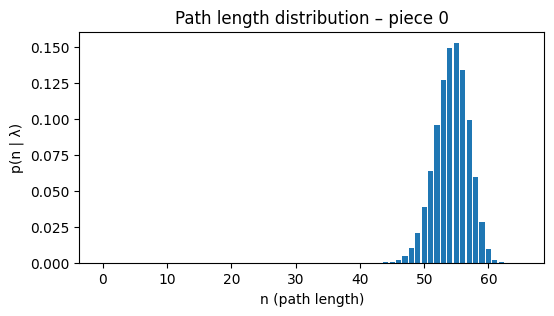

In [ ]:

b = 0
total_count = model.path_log_params[b, 0].exp().item() 
p = model.path_log_params[b, 1].sigmoid().item()

# bound
n_max = min(model.max_iterations, int(total_count) + 5)
ns = torch.arange(0, n_max, dtype=torch.float64)

# p(n | λ)
pn = []
for n in ns:
    pn.append(binom_logprob_manual_kNk(k=n,N=torch.tensor(total_count),p=torch.tensor(p)).exp().item())
    
#normalisation
pn = torch.tensor(pn)
pn = pn / pn.sum()  

# plot
plt.figure(figsize=(6, 3))
plt.bar(ns.numpy(), pn.numpy())
plt.xlabel("n")
plt.ylabel("p(n | λ)")
plt.title(f"Path length distribution for piece {b}")


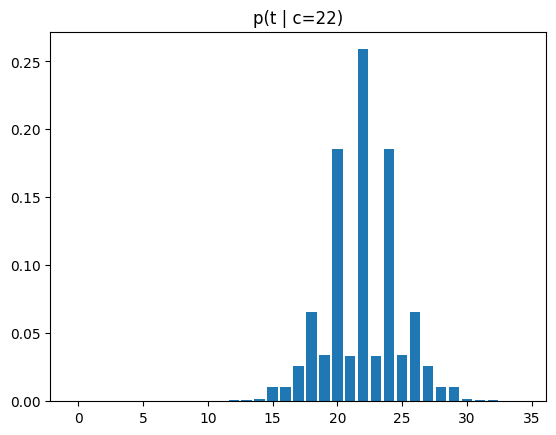

In [ ]:
c0 = 22 
p_tc = model.interval_class_distribution[c0].detach().cpu().numpy()

plt.figure()
plt.bar(range(len(p_tc)), p_tc)
plt.title(f"p(t | c={c0})")

In [ ]:
best_loss_model = float('inf')
best_model_params = None
loss_hist_model = []
for it in tqdm(range(800)):          
    optimizer.zero_grad()
    loss = model._loss()       # closure in parent computes loss using self.interval_class_distribution
    loss.backward()
    optimizer.step()
    val = loss.item()
    loss_hist_model.append(val)
    # early stopping
    if val < best_loss_model:
        best_loss_model = val
        best_model_params = model.get_params()
    if it % 100 == 0:
        print(f"it {it} loss {loss.item():.6f}")
model.set_params(best_model_params)

  0%|          | 1/800 [00:01<14:33,  1.09s/it]

it 0 loss 1.727974


 13%|█▎        | 101/800 [01:45<11:43,  1.01s/it]

it 100 loss 0.415870


 25%|██▌       | 201/800 [03:31<11:20,  1.14s/it]

it 200 loss 0.377355


 38%|███▊      | 301/800 [05:15<08:34,  1.03s/it]

it 300 loss 0.369872


 50%|█████     | 401/800 [07:01<07:43,  1.16s/it]

it 400 loss 0.367662


 63%|██████▎   | 501/800 [08:47<05:29,  1.10s/it]

it 500 loss 0.366647


 75%|███████▌  | 601/800 [10:35<03:30,  1.06s/it]

it 600 loss 0.366421


 88%|████████▊ | 701/800 [12:18<01:43,  1.04s/it]

it 700 loss 0.366548


100%|██████████| 800/800 [14:00<00:00,  1.05s/it]


In [15]:
results = model.get_results()["predicted_distribution"]

In [34]:
results


array([[0.01187558, 0.01666706, 0.02050853, ..., 0.00658545, 0.00496933,
        0.00306199],
       [0.01191075, 0.01671591, 0.02056606, ..., 0.00655228, 0.00494375,
        0.00304588],
       [0.01197367, 0.01680219, 0.020669  , ..., 0.0064937 , 0.00489819,
        0.0030174 ],
       ...,
       [0.00788816, 0.0111834 , 0.013952  , ..., 0.01063496, 0.00812404,
        0.0050372 ],
       [0.00792812, 0.01123851, 0.014018  , ..., 0.01059134, 0.00809003,
        0.00501586],
       [0.00792661, 0.01123709, 0.01401547, ..., 0.01059244, 0.00809132,
        0.00501641]])

In [12]:
dist_c0 = model.interval_class_distribution[10]
dist_c1 = model.interval_class_distribution[11]
torch.norm(dist_c0 - dist_c1)


tensor(0.0189, dtype=torch.float64, grad_fn=<LinalgVectorNormBackward0>)

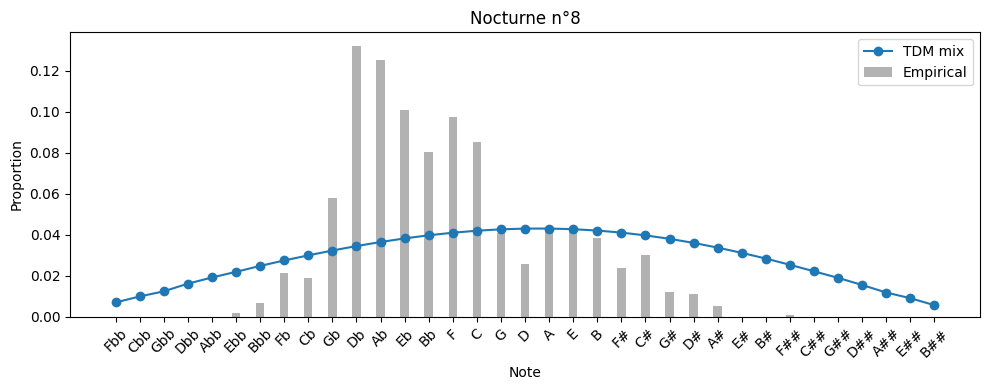

In [35]:
# On pourra changer au besoin l'indice.
idx = 27

empirical = data_second[idx] # la vraie distribution des tpc

x = np.arange(len(notes))

# le plot (barres pour empirical + lignes pour les prédictions)
plt.figure(figsize=(10, 4))
plt.bar(x, empirical, width=0.35, color="gray", alpha=0.6, label="Empirical")
plt.plot(x, results[idx], "-o", color="tab:blue", label="TDM mix")
plt.xticks(x, notes, rotation = 45)
plt.ylabel("Proportion")
plt.xlabel("Note")
plt.title(f"{titles_second[idx]}")
plt.legend()
plt.tight_layout()
plt.show()